In [70]:
import torch
import torchaudio

import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import matplotlib.pyplot as plt
from IPython.display import Audio as PlayAudio
import librosa
import numpy as np
import math

2.6.0
2.6.0


In [71]:
class Obj12TET:
    NAMING_CONVENTIONS = {
        "EasternEurope": {
            "names": {'A', 'B', 'H', 'C', 'D', 'E', 'F', 'G'},
            "distances": {'A': 9, 'B': 10, 'H': 11, 'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7}
        },
        "English": {
            "names": {'A', 'B', 'C', 'D', 'E', 'F', 'G'},
            "distances": {'A': 9, 'H': 11, 'C': 0, 'D': 2, 'E': 4, 'F': 5, 'G': 7}
        }}
    POSSIBLE_CHROMATICS = {
        "" : 0,
        "#": 1, "##": 2,
        "b": -1, "bb": -2,
    }
    MAX_NOTE_NUMB = 8  # Maximum number by the note (eg 'A8')

    def __init__(self, tuning=440, conv="EasternEurope"):
        self._NOTES_AND_DISTANCES = self.NAMING_CONVENTIONS[conv]
        self._C0_freq = tuning * pow(2, -4 - 9/12)


In [72]:
# class Key(Obj12TET):
#     def __init__(self,letter, , tuning=440, conv="EasternEurope"):
#         super().__init__(tuning, conv)
#

In [73]:
class NoteTone(Obj12TET):
    def __init__(self, label, tuning=440, conv="EasternEurope"):
        super().__init__(tuning, conv)
        self._letter, self._number, self._chromatics = self.label_to_note_params(label)
        self._dist_from_C0 = self.calc_dist()
        self._frequency = self.calc_frequency()

    def calc_dist(self):
        letter_adjust = self._NOTES_AND_DISTANCES["distances"][self._letter]
        octaves = 12 * self._number
        chrom_adjust = self.POSSIBLE_CHROMATICS[self._chromatics]
        return letter_adjust + octaves + chrom_adjust

    def calc_frequency(self):
        exponent = self._dist_from_C0 / 12
        return self._C0_freq * pow(2, exponent)

    def label_to_note_params(self, label):
        letter = label[0]
        number = int(label[len(label) - 1])
        chromatics = ""
        if len(label) == 3:
            chromatics = label[1]
        elif len(label) == 4:
            chromatics = label[1:2]
        return letter, number, chromatics

    def print(self):
        print(self._letter + self._chromatics + str(self._number) + ": " + str(round(self._frequency, 2)) + " Hz")

    def set_by_frequency(self, freq, key='C',):
        self._dist_from_C0 = self.frequency_to_dist(freq)
        print("Dist form C0: "+ str(self._dist_from_C0))
        self._letter, self._number, self._chromatics = self.dist_to_note()
        self._frequency=self.calc_frequency()

    def frequency_to_dist(self, freq):
        freq_ratio = freq / self._C0_freq
        return round(12 * math.log2(freq_ratio))

    def dist_to_note(self):
        dist = self._dist_from_C0
        number = str(int(dist / 12))
        for name in self._NOTES_AND_DISTANCES["names"]:
            if self._NOTES_AND_DISTANCES["distances"][name] == dist % 12:
                return name, "", number
        for name in self._NOTES_AND_DISTANCES["names"]:
            if self._NOTES_AND_DISTANCES["distances"][name] + 1 == dist % 12:
                return name, "#", number
        return "Not", "a", "note"

In [74]:
A4 = NoteTone("B#2")
A4.print()


B#2: 123.47 Hz


In [75]:
class Audio:
    def __init__(self, path):
        self.WAVE_FORM, self.SAMPLE_RATE = torchaudio.load(path)

    def plot_waveform(self, title="Waveform", ax=None):
        waveform = self.WAVE_FORM.numpy()
        num_channels, num_frames = waveform.shape
        time_axis = torch.arange(0, num_frames) / self.SAMPLE_RATE
        if ax is None:
            fig, ax = plt.subplots(num_channels, 1, figsize=(8, 2))
        ax.plot(time_axis, waveform[0], linewidth=1)
        ax.grid(True)
        ax.set_title(title)

    def play(self):
        return PlayAudio(self.WAVE_FORM.numpy(), rate = self.SAMPLE_RATE)

    def plot_spectogram(self, title=None, ax=None, y_label='freq_bin'):
        spectogram = T.Spectrogram(n_fft=512, normalized=True)
        spec = spectogram(self.WAVE_FORM)
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(6, 3))
        if title is not None:
            ax.set_title(title)
        ax.set_ylabel(y_label)
        data = librosa.power_to_db(spec[0])
        y = np.logspace(0, 3, data.shape[0])
        ax.imshow(
            data,
            origin='lower',
            aspect='auto',
            interpolation='nearest',
            extent=[0, data.shape[1], y[0], y[-1]]
        )
        ax.set_yscale('log')

    def plot_pitch(self, freq_high=1400):
        waveform = self.WAVE_FORM
        sr = self.SAMPLE_RATE
        pitch = F.detect_pitch_frequency(waveform, sr, freq_high=freq_high)
        figure, axis = plt.subplots(1, 1)
        axis.set_title("Pitch Feature")
        axis.grid(True)

        end_time = waveform.shape[1] / sr
        time_axis = torch.linspace(0, end_time, waveform.shape[1])
        axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

        axis2 = axis.twinx()
        time_axis = torch.linspace(0, end_time, pitch.shape[1])
        axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

        axis2.legend(loc=0)

In [76]:
class SampleAudio(Audio):
    def __init__(self, path):
        super().__init__(path)
        self.trim_beg()

    def trim_beg(self):
        energy = torch.max(torch.abs(self.WAVE_FORM), dim=0).values
        max_energy = torch.max(energy)
        threshold = 0.8 * max_energy
        non_silent = torch.where(energy > threshold)[0]
        start_sample = non_silent[0]
        self.WAVE_FORM = self.WAVE_FORM[:, start_sample:]

In [77]:
from scipy.stats import gaussian_kde
class SingleToneSample(SampleAudio):
    def __init__(self, path, freq_high=1400, tuning=440, conv="EasternEurope"):
        super().__init__(path)
        self.note = NoteTone("A0", tuning=tuning, conv=conv)
        self.detect_tone(freq_high)

    def detect_tone(self, freq_high=1400):
        waveform = self.WAVE_FORM
        sr = self.SAMPLE_RATE
        pitch = F.detect_pitch_frequency(waveform, sr, freq_high=freq_high).numpy()
        pitch = pitch[(pitch > 15) & (pitch < freq_high)]
        pitch = pitch.ravel()
        std = np.std(pitch)
        if std < 0.5:   # Jeśli dane są "płaskie"
            mode_value = np.median(pitch)
        else:          # Jeśli są zaburzenia
            kde = gaussian_kde(pitch)
            x = np.linspace(pitch.min(), pitch.max(), 1000)
            mode_value = x[np.argmax(kde(x))]

        print("Measured freq:", mode_value)
        self.note.set_by_frequency(mode_value)


Measured freq: 109.97507
Dist form C0: 33
A2: 110.0 Hz


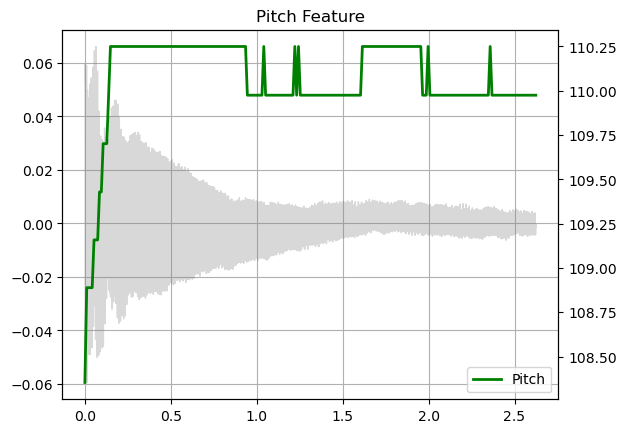

In [83]:
PATH = "Raw_Audio_Data/A2/10.wav"
tone = SingleToneSample(PATH)
tone.note.print()
tone.plot_pitch()

Measured freq: 146.51163
Dist form C0: 38


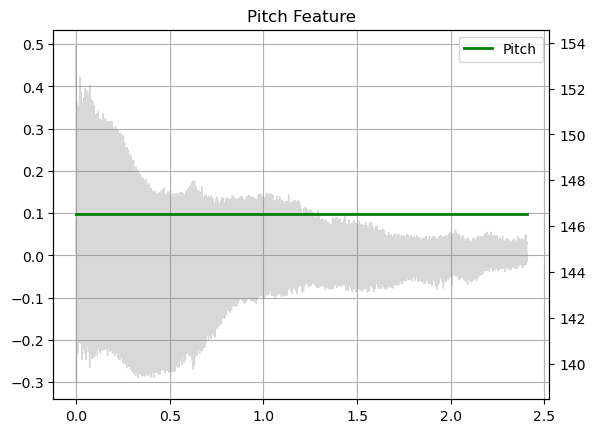

In [82]:
tone2 = SingleToneSample("Raw_Audio_Data/D3/2.wav")
tone2.plot_pitch()